In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
Xtr = pd.read_csv('Xtr.csv')
Ytr = pd.read_csv('Ytr.csv')
Xte = pd.read_csv('Xte.csv')

In [97]:
# Printimg type of data
Xtr.shape

(2000, 2)

In [98]:
Ytr.head()

,Id,Bound
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1


In [99]:
# Reading data in vector form
Xtr_mat100 = pd.read_csv( 'Xtr_mat100.csv', header=None, sep=' ')
Xte_mat100 = pd.read_csv( 'Xte_mat100.csv', header=None, sep=' ')

In [100]:
#Encode the sequence to vectors

Word_length = 7
base = {'A':0, 'C':1, 'T':2, 'G':3}
index_size = 4**Word_length


def word_to_index(word):
    index = 0
    for i, carac in enumerate(word):
        index += base[carac] * (4 ** i)
    return index

def encode_sequence(seq, word_len=Word_length):
    encoded = np.zeros(index_size)
    for i in range(len(seq) - word_len+1):
        word = seq[i:(i+word_len)]
        index = word_to_index(word)
        encoded[index] += 1
    return encoded

def bags_of_word_transform(data_column, word_len):
    encoded_column = data_column.apply(encode_sequence, word_len=Word_length)
    encoded_column = np.stack(encoded_column)
    return encoded_column



In [163]:
Xtr_encode = bags_of_word_transform(Xtr.seq, word_len=7)
Xtr_encode

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [168]:
X_train_encoded = Xtr.seq.apply(encode_sequence)
X_train_encoded = np.stack(X_train_encoded)
print('X_train_encoded', Xtr_encoded.shape)
print('max: {}, mean: {}'.format(X_train_encoded.max(), X_train_encoded.mean()))
print('non zeros: {}, zeros: {},'.format(np.sum(X_train_encoded==0), np.sum(X_train_encoded!=0)))
print('ratio: {}'.format(np.sum(X_train_encoded!=0)/(X_train_encoded.shape[0]*X_train_encoded.shape[1])))

X_train_encoded (2000, 16384)
max: 15.0, mean: 0.00579833984375
non zeros: 32581343, zeros: 186657,
ratio: 0.005696319580078125


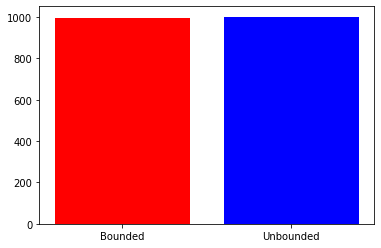

In [104]:
# Visualize the sequence data
from collections import Counter

from matplotlib import pyplot as plt
idx = np.arange(2)
typ_ = [i for i in Counter(Ytr.Bound).keys()]
freq_ = [i for i in Counter(Ytr.Bound).values()]
plt.bar(idx,freq_,color=["red","blue"])
plt.xticks(idx,["Bounded","Unbounded"])
plt.show()

In [165]:
Counter(Ytr.Bound)

Counter({1: 998, 0: 1002})

In [166]:
Ytr1 = Ytr.Bound.values.copy()
Ytr1[Ytr1 ==0]=-1

In [169]:
# Splitting the dataset into the training set and valid set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, 
                                                    Ytr1, 
                                                    test_size = 0.33, 
                                                    random_state=42)

In [108]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1340, 16384), (1340,), (660, 16384), (660,))

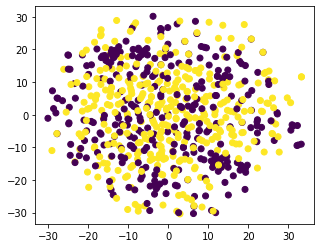

In [174]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X_embeding = PCA(n_components=2).fit_transform(X_train)
#embeding
#X_embeding = TSNE(n_components=2).fit_transform(X_train, y_train)
Valid_embeding = TSNE(n_components=2).fit_transform(X_val, y_val)

plt.figure(figsize=(5,4))
plt.scatter(Valid_embeding[:, 0], Valid_embeding[:, 1], c=y_val)


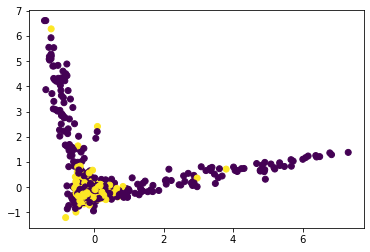

In [173]:
plt.scatter(X_embeding[:, 0], X_embeding[:, 1], c=y_train)


In [110]:
def rbf_kernel(X1, X2, sigma=1):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the RBF kernel with parameter sigma
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    sigma: float
    '''
    # Use matrix operations!
    X2_norm = np.sum(X2 ** 2, axis = -1)
    X1_norm = np.sum(X1 ** 2, axis = -1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K

def sigma_from_median(X):
    '''
    Returns the median of ||Xi-Xj||
    
    Input
    -----
    X: (n, p) matrix
    '''
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)


def linear_kernel(X1, X2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the linear kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return X1.dot(X2.T)

def quadratic_kernel(X1, X2,power=2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the quadratic kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return (1 + linear_kernel(X1, X2))**power 

In [175]:
#Define Ridge Classifier

kernel_dict  = {
    'linear' : linear_kernel, 
    'rbf' : rbf_kernel,
    'quadratic' : quadratic_kernel,
    'spectrum' : SpectrumKernel
}
class RidgeClassifier():
    def __init__(self, lamdb=0.01, kernel='rbf', **kernel_params):
        # hyper parameter
        self.lamdb = lamdb
        self.kernel = kernel
        self.kernel_params = kernel_params

        # train parameter
        self.beta = None
        self.kernel_func = kernel_dict[kernel]

    def fit(self, X, y):
        #save train to be used for prediction
        self.X_train = X
        
        #maximum likehood estimator
        n, p = X.shape
        I = np.eye(n)
        A = self.kernel_func(X, X, **self.kernel_params) + self.lamdb  *n * I
        self.beta = np.linalg.solve(A, y)

    def predict(self, X):
        output = self.kernel_func(X, self.X_train, **self.kernel_params) @ self.beta
        y_pred = np.sign(output)

        return y_pred
    
    def score(self, X, y):
        pred = self.predict(X)
        accuracy = np.mean(pred==y)
        return accuracy
    
    
    ### For sklearn compatibility
    def get_params(self, deep=True):
        return {'lamdb':self.lamdb, 'kernel': self.kernel, **self.kernel_params}

    ### For sklearn compatibility
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [160]:
from sklearn.model_selection import cross_val_score
def random_range(begin, end):
    return (end-begin)*np.random.rand() + begin
for i in range(30):
    lamdb = 10**random_range(-10, -1)
    #lamdb = 1.25e-08
    sigma = random_range(5, 10)
    #sigma = 6.08

    clf = RidgeClassifier(kernel='rbf', lamdb=lamdb, sigma=sigma) #k = 4)#)

    scores = cross_val_score(clf, X_train, y_train, cv=5)
    mean_acc = scores.mean()
    std_acc  = scores.mean()

    
    print(f'{i}: lamdb={lamdb:.02e}, sigma={sigma:.02f} mean_accuracy {100*mean_acc:.2f} - {std_acc:.02e}')

0: lamdb=2.58e-02, sigma=9.17 mean_accuracy 54.55 - 5.46e-01
1: lamdb=1.90e-04, sigma=8.25 mean_accuracy 66.27 - 6.63e-01
2: lamdb=8.33e-03, sigma=9.00 mean_accuracy 66.27 - 6.63e-01
3: lamdb=1.38e-04, sigma=7.55 mean_accuracy 66.12 - 6.61e-01
4: lamdb=2.02e-02, sigma=8.44 mean_accuracy 58.58 - 5.86e-01
5: lamdb=1.21e-02, sigma=5.27 mean_accuracy 54.55 - 5.46e-01
6: lamdb=1.19e-04, sigma=6.14 mean_accuracy 66.79 - 6.68e-01
7: lamdb=5.18e-02, sigma=8.18 mean_accuracy 52.09 - 5.21e-01
8: lamdb=8.33e-08, sigma=5.37 mean_accuracy 66.64 - 6.66e-01
9: lamdb=1.14e-07, sigma=5.08 mean_accuracy 66.42 - 6.64e-01
10: lamdb=7.55e-06, sigma=8.55 mean_accuracy 65.90 - 6.59e-01
11: lamdb=6.73e-09, sigma=5.00 mean_accuracy 66.27 - 6.63e-01
12: lamdb=2.20e-03, sigma=7.06 mean_accuracy 66.49 - 6.65e-01
13: lamdb=2.48e-05, sigma=9.89 mean_accuracy 65.97 - 6.60e-01
14: lamdb=2.70e-02, sigma=7.84 mean_accuracy 53.73 - 5.37e-01
15: lamdb=8.03e-06, sigma=8.86 mean_accuracy 66.04 - 6.60e-01
16: lamdb=5.42e-03

In [161]:
#clf = RidgeClassifier(lamdb=2.67e-07, sigma=6.08)
clf = RidgeClassifier(lamdb=3.36e-03, sigma=7.44)#== 67.88
#clf = RidgeClassifier(lamdb=3.25e-09, sigma=6.08) ==67.58
#clf = RidgeClassifier(lamdb=1.01e-06, sigma=5.24) == 66.67
#clf = RidgeClassifier(lamdb=1.9e-08, sigma=5.3) ==66.79

clf.fit(X_train, y_train)

acc_train = clf.score(X_train, y_train)
acc_val   = clf.score(X_val,   y_val)

f'Accuracy on Train {100*acc_train:.2f} and Valid {100*acc_val:.2f}'

'Accuracy on Train 99.55 and Valid 67.88'

In [118]:
X_test_encode = bags_of_word_transform(Xte.seq, word_len=7)
X_test_encode.shape

(1000, 16384)

In [119]:
# pred = clf.predict(Xte_mat100.values)
pred = clf.predict(X_test_encode)
pred[ pred == -1] = 0
pred = pred.astype(int)


submission = pd.DataFrame({'Bound': pred})
submission.index.name = 'Id'

submission.head()

,Bound
Id,
0,1
1,1
2,0
3,0
4,1


In [120]:
submission.to_csv('pp_bow1.csv')

In [121]:
df = pd.read_csv('pp_bow1.csvv')
df.shape

(1000, 2)